
# Data-analyysityöpaja Tieteen päivillä

Mitä data-analyysi on? Data-analyysi tarkoitaa sitä, että datan pohjalta päätellään jotain uutta. Esimerkiksi mittausdatan perusteella voidaan todeta, että uusi lääkeaine näyttää laskevan verenpainetta.

No mitä se data on? Nykypäivänä data voi olla mitä tahansa, mikä on saatavissa digitaalisessa muodossa. Perinteisesti data on ollut tieteellisiä havaintoja, joita on tunnollisesti kirjattu ylös, vaikkapa jonkinlaiseksi taulukoksi. Näin on edellisen verenpaine-esimerkin tapauksessa. Nykyään kuitenkin tehdään jo paljon analyysiä esimerkiksi reaaliaikaisesta videokuvasta. Hyvä esimerkki tästä on vaikkapa robottilennokki, joka lentää pitkin voimalinjoja ja videokameran kuvan avulla analysoi, että milloin lumikuorma on vaarallisen suuri.

Mihin data-analyysia tarvitaan? Jos visionäärejä on uskominen, niin kohta ihan kaikkeen. Tieteessä datan analysointi on ollut keskeistä viimeistään 1900-luvun alusta alkaen. Tämä perinteinen tieteen ja asiantuntijatyön analytiikka on kuitenkin nyt saamassa rinnalleen uuden käyttäjäkunnan, kun arkisemmat data-analyysitarpeet ovat suoraan sanoen räjähtäneet. Facebookin ja Googlen kaltaiset internetajan yritykset vetävät uuden data-analytiikan nopeaa kehitystä. Yritysmaailmassa niin kutsuttu Big Data on tällä hetkellä hyvin kuuma aihe.

Joka tapauksessa on selvää, että tulevaisuudessa data-analyysiä tehdään paljon enemmän ja paljon laajemmin. Eli ei pelkästään tutkimuslaitoksissa, vaan myös tavallisissa yrityksissä, virastoissa ja järjestöissä. Jos opettelee ainakin perusasiat, niin saa melkoisen hyödyn tulevaisuutta ajatellen.

# Alku

Ensiksi alustamme koneoppimisen työkalumme ja lataamme datan, jota työpajassa käsitellään. Alla oleva koodinpätkä tekee nämä kaksi asiaa.

Koodi ajetaan klikkaamalla harmaaseen laatikkoon, jolloin se tulee valituksi. Valitse ylävalikosta Cell -> Run ja koodi käynnistyy. Sen merkkinä ilmestyy In-riville tähti. Kun homma on valmis, niin alle ilmestyvät tulokset. Tässä tapauksessa pitäisi tulla tieto ladatun datan koosta sekä esimerkiksi muutamia merkkejä, joita data sisältää.

Jatkossa koodin voi ajaa myös näppärämmin painamalla Ctrl ja Enter.

In [2]:
# Alustetaan koneoppimisen ympäristö (ohjelmakirjastot)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from time import time
import numpy as np
from sklearn import random_projection, decomposition, manifold
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist

# Ladataan data (MNIST-tietokanta)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = X_train[:1024]
y = y_train[:1024]

print('\nData ladattu onnistuneesti (MNIST).')
print('Datan palasten koko: train:',len(X_train),'test:',len(X_test))



Data ladattu onnistuneesti (MNIST).
Datan palasten koko: train: 60000 test: 10000


Seuraavaksi piirretään 1024 ensimmäistä käsin kirjoitettua merkkiä (numeroa), jotka datasta löytyvät.

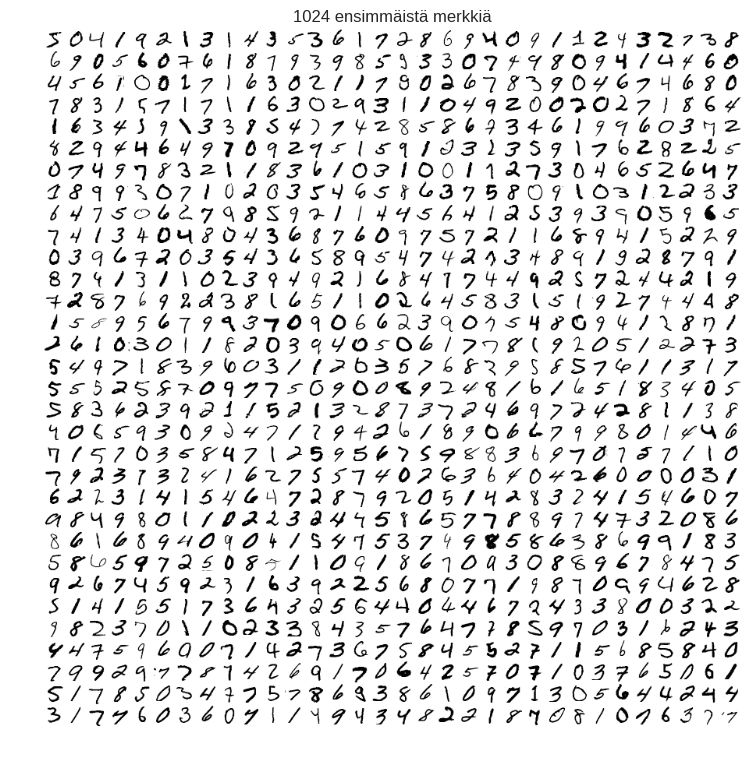

In [3]:
n_img_per_row = 32 # 32*32=1024
img = np.zeros((28 * n_img_per_row, 28 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 28 * i
    for j in range(n_img_per_row):    
        iy = 28 * j
        img[ix:ix + 28, iy:iy + 28] = X[i * n_img_per_row + j,:,:]

plt.figure(figsize=(9, 9))
plt.imshow(img)
plt.title('1024 ensimmäistä merkkiä')
ax=plt.axis('off')

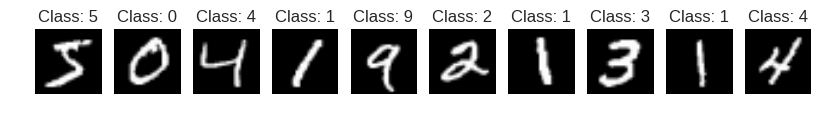

In [4]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:], cmap="gray")
    plt.title('Class: '+str(y_train[i]))


## Ensimmäinen koneoppimistehtävä

[Principal component analysis](http://scikit-learn.org/stable/modules/decomposition.html#pca) (PCA) is a standard method to decompose a high-dimensional dataset in a set of successive orthogonal components that explain a maximum amount of the variance. Here we project the data into two first principal components. The components have the maximal possible variance under the orthogonality constraint.

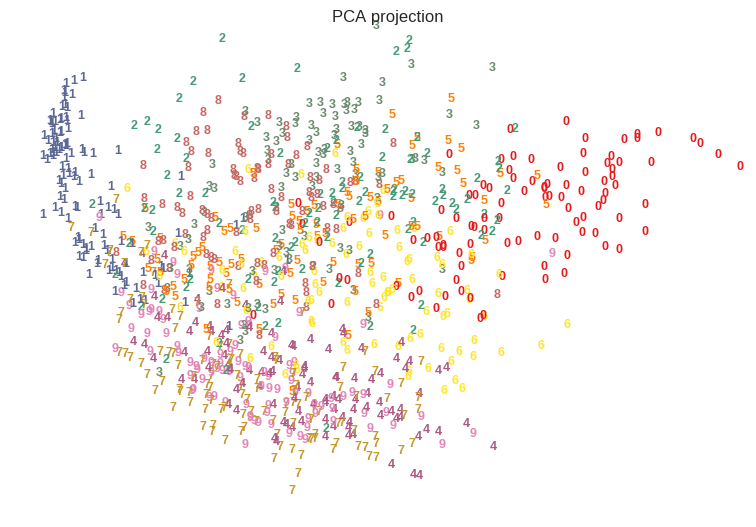

In [6]:
def plot_embedding(X, title=None, t0=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(9,6))
    plt.axis('off')
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if title is not None:
        if t0 is not None:
            plt.title("%s (%.2fs)" % (title, (time()-t0)))
        else:
            plt.title(title)
            
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X.reshape(-1,28*28))
plot_embedding(X_pca, "PCA projection")

## Vähän tilastollista ajattelua

A simple first visualization is a [random projection](http://scikit-learn.org/stable/modules/random_projection.html#random-projection) of the data into two dimensions.

Notice the `reshape(-1,28*28)` function which flattens the 2-D images into 1-D vectors (from 28*28 pixel images to 784-dimensional vectors).

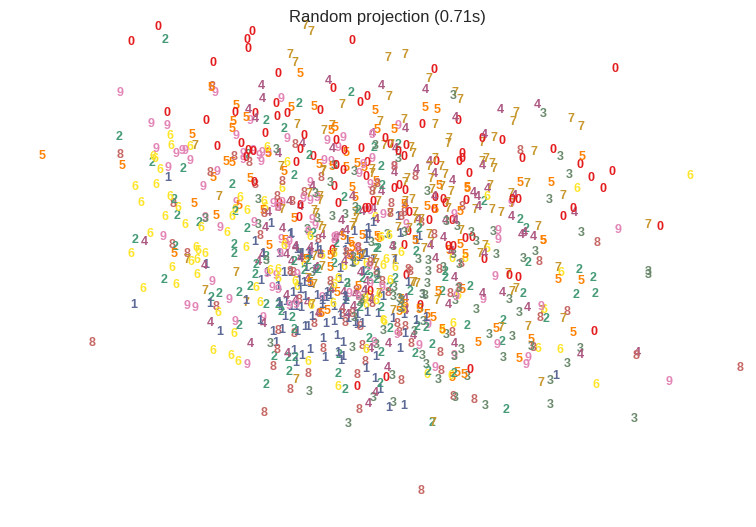

In [7]:
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X.reshape(-1,28*28))
plot_embedding(X_projected, "Random projection")

## Merkkien tunnistaminen

In [10]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train.reshape(-1,28*28), y_train)
pred_dt = clf_dt.predict(X_test.reshape(-1,28*28))
print('Predicted', len(pred_dt), 'digits with accuracy:', accuracy_score(y_test, pred_dt))


Predicted 10000 digits with accuracy: 0.8785


## Kuinka fiksu se systeemi on?

In [11]:
X_test_noisy = np.zeros((len(X_test), 28, 28))
for i in range(len(X_test)):
    X_test_noisy[i,:,:] = 0.5*X_test[i,:,:] + 0.5*np.random.rand(28,28)*255


In [12]:
clf_dt_noisy = DecisionTreeClassifier()
clf_dt_noisy.fit(X_train.reshape(-1,28*28), y_train)
pred_dt_noisy = clf_dt_noisy.predict(X_test_noisy.reshape(-1,28*28))
print('Predicted', len(pred_dt_noisy), 'digits with accuracy:', accuracy_score(y_test, pred_dt_noisy))

Predicted 10000 digits with accuracy: 0.1409


## Ja lopuksi neuvoverkkoja

http://playground.tensorflow.org/

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model initialization:
model = Sequential()

# A simple model:
model.add(Dense(20, input_dim=28*28))
model.add(Activation('relu'))

# A bit more complex model:
#model.add(Dense(50, input_dim=28*28))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

#model.add(Dense(50))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))

# The last layer needs to be like this:
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])


In [14]:
# one-hot encoding:
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


nb_epoch = 10 # one epoch with simple model takes about 4 seconds

history = model.fit(X_train.reshape((-1,28*28)), 
                    Y_train, 
                    nb_epoch=nb_epoch, 
                    batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 6s - loss: 5.0431 - acc: 0.6788     
Epoch 2/10
60000/60000 [==============================] - 6s - loss: 3.1437 - acc: 0.7994     
Epoch 3/10
60000/60000 [==============================] - 6s - loss: 2.8698 - acc: 0.8178     
Epoch 4/10
60000/60000 [==============================] - 6s - loss: 2.7659 - acc: 0.8253     
Epoch 5/10
60000/60000 [==============================] - 6s - loss: 2.7109 - acc: 0.8293     
Epoch 6/10
60000/60000 [==============================] - 6s - loss: 2.6239 - acc: 0.8346     
Epoch 7/10
60000/60000 [==============================] - 6s - loss: 2.4560 - acc: 0.8449     
Epoch 8/10
60000/60000 [==============================] - 7s - loss: 1.5170 - acc: 0.9029     
Epoch 9/10
60000/60000 [==============================] - 6s - loss: 1.4051 - acc: 0.9107     
Epoch 10/10
60000/60000 [==============================] - 7s - loss: 1.3645 - acc: 0.9130     


In [15]:
scores = model.evaluate(X_test.reshape((-1,28*28)), Y_test, verbose=1)
print()
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

 9888/10000 [============================>.] - ETA: 0s
acc: 89.64%


Wrong predictions: 1036
Showing 10 first failures.  The predicted class is shown first and the correct class in parenthesis.


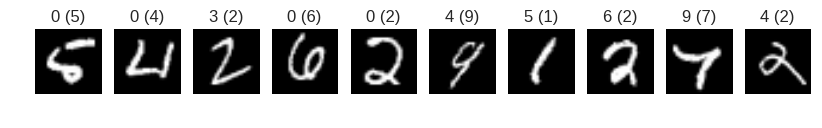

In [16]:
predictions = model.predict(X_test.reshape((-1,28*28)))
rounded = np.argmax(predictions, axis=1)
errors = rounded != y_test
nerrors = np.count_nonzero(errors)
print('Wrong predictions:', nerrors)

maxtoshow = 10
print('Showing', maxtoshow, 'first failures.  The predicted class is shown first and the correct class in parenthesis.')
ii = 0
plt.figure(figsize=(maxtoshow*pltsize, pltsize))
for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(1, maxtoshow, ii+1)
        plt.axis('off')
        plt.imshow(X_test[i,:,:], cmap="gray")
        plt.title("%d (%d)" % (rounded[i], y_test[i]))
        ii = ii + 1